### "State of the art" cup recognition platform

- Interesting read: DL with small dataset - https://towardsdatascience.com/how-to-use-deep-learning-even-with-small-data-e7f34b673987

In [1]:
# Different useful libraries
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import glob
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# ANN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Helpers
from helpers import *
%run helpers.py

### Data loading

In [3]:
############################
###### Agumented Data ######
############################

aug_cups, aug_cup_size = import_images(path='henriks_images/augment_cup/')
aug_boxes, aug_box_size = import_images(path='henriks_images/augment_box/')
aug_books, aug_book_size = import_images(path='henriks_images/augment_book/')


aug_data, aug_labels = from_raw_to_CNN(aug_cups, aug_boxes, aug_books, aug_cup_size, aug_box_size, aug_book_size, resize=False)

(2016, 128, 128, 1) (2016,)


In [4]:
########################
###### Test data  ######
########################
real_cups, real_cup_size = import_images(path='test_samples/cups/')
real_boxes, real_box_size = import_images(path='test_samples/boxes/')
real_books, real_book_size = import_images(path='test_samples/books/')

test_data, test_labels = from_raw_to_CNN(real_cups, real_boxes, real_books, real_cup_size, real_box_size, real_book_size);

c:\Users\henri\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(26, 128, 128, 1) (26,)


In [5]:
############################
###### Training data  ######
############################

raw_cups, raw_cup_size = import_images(path='henriks_images/small_cup/')
raw_boxes, raw_box_size = import_images(path='henriks_images/small_box/')
raw_books, raw_book_size = import_images(path='henriks_images/small_book/')

raw_data, raw_labels = from_raw_to_CNN(raw_cups, raw_boxes, raw_books, raw_cup_size, raw_box_size, raw_book_size, resize=False);

(672, 128, 128, 1) (672,)


In [6]:
def convert_to_CNN(cups, boxes, books, cupsize, boxsize, booksize, resize=True):
    # Reshape
    if resize:
        real_cups = resize_and_flatten(cups, padding=False, max_size=cupsize, output_size=128, flatten=False)
        real_boxes = resize_and_flatten(boxes, padding=False, max_size=boxsize, output_size=128, flatten=False)
        real_books = resize_and_flatten(books, padding=False, max_size=booksize, output_size=128, flatten=False)
    else:
        real_cups =cups.copy()
        real_boxes=boxes.copy()
        real_books=books.copy()
    # Scale
    real_cups = real_cups / 255
    real_boxes = real_boxes / 255
    real_books = real_books / 255
    # Shape for KERAS
    #a, b, c = real_cups.shape
    # real_cups = real_cups.reshape((a,b,c,3))
    # a, b, c = real_boxes.shape
    # real_boxes = real_boxes.reshape((a,b,c,3))
    # a, b, c = real_books.shape
    # real_books = real_books.reshape((a,b,c,3))
    real_cups = np.expand_dims(real_cups,axis=-1)
    real_boxes = np.expand_dims(real_boxes,axis=-1)
    real_books = np.expand_dims(real_books,axis=-1)
    real_cups = np.concatenate((real_cups,real_cups,real_cups), axis=-1)
    real_boxes = np.concatenate((real_boxes, real_boxes, real_boxes), axis=-1)
    real_books = np.concatenate((real_books, real_books, real_books), axis=-1)
    
    # # Targets cups, boxes = [0, 1]
    cup_target = np.zeros((len(real_cups),))
    box_target = np.ones((len(real_boxes),))
    book_target = np.ones((len(real_books),))*2

    # Combine the data
    test_data = np.concatenate((real_cups, real_boxes, real_books))
    test_targets = np.concatenate((cup_target, box_target, book_target))

    print(test_data.shape, test_targets.shape)
    return test_data, test_targets

In [7]:
raw_data2, raw_labels2 = convert_to_CNN(raw_cups, raw_boxes, raw_books, raw_cup_size, raw_box_size, raw_book_size, resize=False);

(672, 128, 128, 3) (672,)


In [8]:
test_data2, test_labels2 = convert_to_CNN(real_cups, real_boxes, real_books, real_cup_size, real_box_size, real_book_size);

(26, 128, 128, 3) (26,)


In [9]:
#########################
###### Cheat data  ######
#########################
cheat_cups, cheat_cup_size = import_images(path='cropped/cup/')
cheat_boxes, cheat_box_size = import_images(path='cropped/box/')
cheat_books, cheat_book_size = import_images(path='cropped/book/')

cheat_data, cheat_labels = from_raw_to_CNN(cheat_cups, cheat_boxes, cheat_books, cheat_cup_size, cheat_box_size, cheat_book_size, resize=False);

(1951, 128, 128, 1) (1951,)


### CNN training time baby!

**CNN model 1 - using no dense hidden layers**
- Working on raw data
- 57.7% accuracy

In [8]:
input_shape = (128, 128, 1)

cnn_model_1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        #layers.Dropout(0.5),
        layers.Dense(3, activation="softmax"), #layers.Dense(2, activation="softmax"),
    ]
)

cnn_model_1.compile(
                loss=tf.keras.metrics.sparse_categorical_crossentropy, #loss="categorical_crossentropy", #loss=tf.keras.metrics.binary_crossentropy, 
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"],
                )


batch_size = 128 # 16, 32, 64, 128
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=10) # 50

cnn_history_1 = cnn_model_1.fit(raw_data, raw_labels,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=0,
            callbacks=[PrintDot(), early_stop] # early_stop
            )


...................................Epoch 00035: early stopping


,loss,accuracy,val_loss,val_accuracy,epoch
34,0.03576,1.0,0.311353,0.882353,34


Test loss: 1.1955498456954956
Test accuracy: 0.5769230723381042


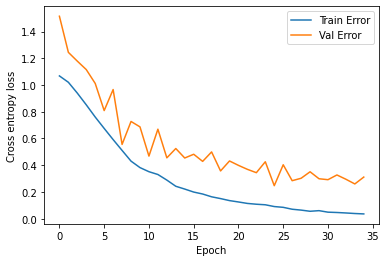

In [9]:
show_final_score(cnn_history_1)

score = cnn_model_1.evaluate(test_data, test_labels, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

**CNN Model 2**
- Same model as model 1, but working on augmented data
- 53% accuracy, and performs worse in every way

In [10]:
input_shape = (128, 128, 1)

cnn_model_2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        #layers.Dropout(0.5),
        layers.Dense(3, activation="softmax"), #layers.Dense(2, activation="softmax"),
    ]
)

cnn_model_2.compile(
                loss=tf.keras.metrics.sparse_categorical_crossentropy, #loss="categorical_crossentropy", #loss=tf.keras.metrics.binary_crossentropy, 
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"],
                )


batch_size = 128 # 16, 32, 64, 128
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=10) # 50

cnn_history_2 = cnn_model_2.fit(raw_data, raw_labels,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=0,
            callbacks=[PrintDot(), early_stop] # early_stop
            )


...........................Epoch 00027: early stopping


,loss,accuracy,val_loss,val_accuracy,epoch
26,0.087533,0.993378,0.523179,0.867647,26


Test loss: 0.8185997009277344
Test accuracy: 0.6153846383094788


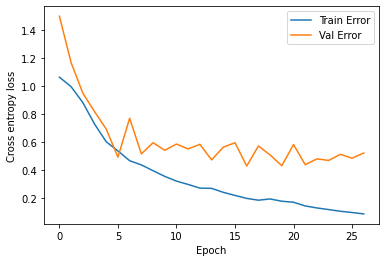

In [11]:
show_final_score(cnn_history_2)

score = cnn_model_2.evaluate(test_data, test_labels, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

**CNN Model 3** Train on cropped data
- Testing out other forms of CNN
- Multiclass, single label classification https://towardsdatascience.com/the-complete-guide-to-neural-networks-multinomial-classification-4fe88bde7839
- CATS and DOGS https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/


In [68]:
input_shape = (128, 128, 1)

cnn_model_3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer='he_uniform', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer='he_uniform', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(32, activation="relu", kernel_initializer='he_uniform'),
        layers.Dense(3, activation="softmax"),
    ]
)

cnn_model_3.compile(
                loss=tf.keras.metrics.sparse_categorical_crossentropy,
                #loss=tf.keras.metrics.categorical_crossentropy, # Only difference to sparse is the format of labels.
                #loss=tf.keras.metrics.binary_crossentropy, 
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"],
                )

#######################
## Cosine similarity ##
########################
#
#cnn_model_3.compile(optimizer=keras.optimizers.Adam(),
#                    loss=tf.keras.losses.cosine_similarity, 
#                    metrics=[tf.keras.metrics.CosineSimilarity(axis=1), "accuracy"])

batch_size = 16 # 16, 32, 64, 128
epochs = 100
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=20) # 50

cnn_history_3 = cnn_model_3.fit(cheat_data, cheat_labels,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=0,
            callbacks=[PrintDot()]#, early_stop] # early_stop
            )


....................................................................................................

,loss,accuracy,val_loss,val_accuracy,epoch
99,9.006916e-08,1.0,0.647836,0.923469,99


Test loss: 3.2170960903167725
Test accuracy: 0.7307692170143127


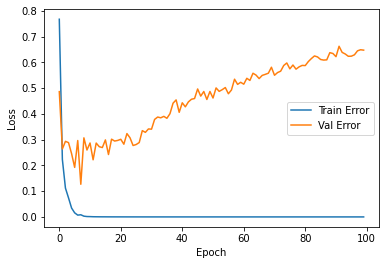

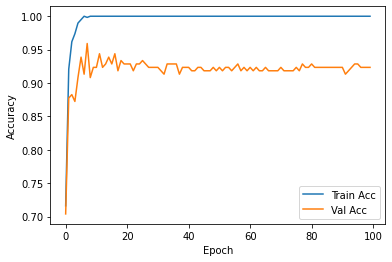

In [70]:
show_final_score(cnn_history_3, loss=True, accuracy=True)

score = cnn_model_3.evaluate(test_data, test_labels, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [71]:
### STORE MODEL FOR LATER USE :D :D

cnn_model_3.save('C:/Users/henri/OneDrive/Desktop/DTU courses/31392 Perception/final_project/FULL_PROJECT/cnn_model_3')

#from tensorflow import keras
#model = keras.models.load_model('path/to/location')

INFO:tensorflow:Assets written to: C:/Users/henri/OneDrive/Desktop/DTU courses/31392 Perception/final_project/FULL_PROJECT/cnn_model_3\assets


**Some experimenting**
Training on the same raw data, with simple tweaks: 
- Adding a large dense layer => Much better fit on training data, but sucks at test data (50%)
- Adding the cheat data to the training data - gets a 30% despite a 80% validation accuracy. I guess it just ignores the cheat data, as its so few datapoints.

Testing out the cosine similarity: Which is a lot more effective for small datasets!
- The loss is now negative for some reason, and the "Test accuracy: 0.7692306041717529" is not to be trusted.

**CNN Model 4** - pretrained model MobileNet

In [63]:
from tensorflow.keras.applications.mobilenet import MobileNet

input_shape = (128, 128, 3)

cnn_model_4 = keras.Sequential()
cnn_model_4.add(MobileNet(include_top=False,input_shape=input_shape))
cnn_model_4.add(layers.Flatten())
cnn_model_4.add(layers.Dense(16,activation="relu"))
cnn_model_4.add(layers.Dense(3,activation="softmax"))

cnn_model_4.compile(optimizer=keras.optimizers.Adam(),
                    loss=tf.keras.losses.sparse_categorical_crossentropy,
                    metrics=["accuracy"])
                    #metrics=[tf.keras.metrics.CategoricalCrossentropy, "accuracy"])


batch_size = 32 # 16, 32, 64, 128
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=10) # 50

cnn_history_4 = cnn_model_4.fit(raw_data2, raw_labels2,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=0,
            callbacks=[PrintDot(), early_stop] # early_stop
            )


.............Epoch 00013: early stopping


,loss,accuracy,val_loss,val_accuracy,epoch
12,0.091121,0.993378,0.0,1.0,12


Test loss: 1.4346593618392944
Test accuracy: 0.6153846383094788


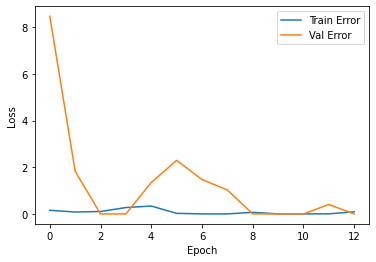

In [64]:
show_final_score(cnn_history_4)

score = cnn_model_4.evaluate(test_data2, test_labels2, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [65]:
#Save model for later use
cnn_model_4.save("model.h5")

In [87]:
from math import ceil
def plot_grid(img, labels, pred, labels_dic, dims=()):
    assert len(img) == len(pred), "Data and Predictions must match in the 1-D"

    if len(dims) == 0:
        n_rows = ceil(len(pred))
        dims = (n_rows, n_rows)

    fig, axes = plt.subplots(dims[0], dims[1],figsize=(10,10))

    for i in range(dims[0]):
        for j in range(dims[1]):
            idx = i*dims[0] + j
            axes[i][j].set_axis_off()
            if idx < len(pred):
                axes[i][j].imshow(img[idx,...], interpolation="nearest")
                label = labels_dic[labels[idx]]
                
                if pred is not None:
                    prediction = labels_dic[np.argmax(pred[idx,...])]
                if label == prediction:
                    axes[i][j].set_title(prediction, color='white')
                else:
                    axes[i][j].set_title(prediction, color='red')
  
    fig.set_tight_layout(True)

    return fig

In [90]:
import random

n_imgs = 6
rand_sec = random.sample(range(0,len(test_data2)), n_imgs)
print(rand_sec)
test_data_show, test_labels_show = [], []
for i in rand_sec:
    test_data_show.append(test_data2[i])
    test_labels_show.append(test_labels2[i])

test_data_show = np.array(test_data_show)
test_labels_show = np.array(test_labels_show)

pred = []
for img in test_data_show:
    temp_pred = cnn_model_4.predict(np.expand_dims(img, 0))
    pred.append(temp_pred)

pred = np.squeeze(np.array(pred), axis=1)
print(test_data_show.shape, test_labels_show.shape, pred.shape)

[20, 14, 10, 5, 17, 6]
(6, 128, 128, 3) (6,) (6, 3)


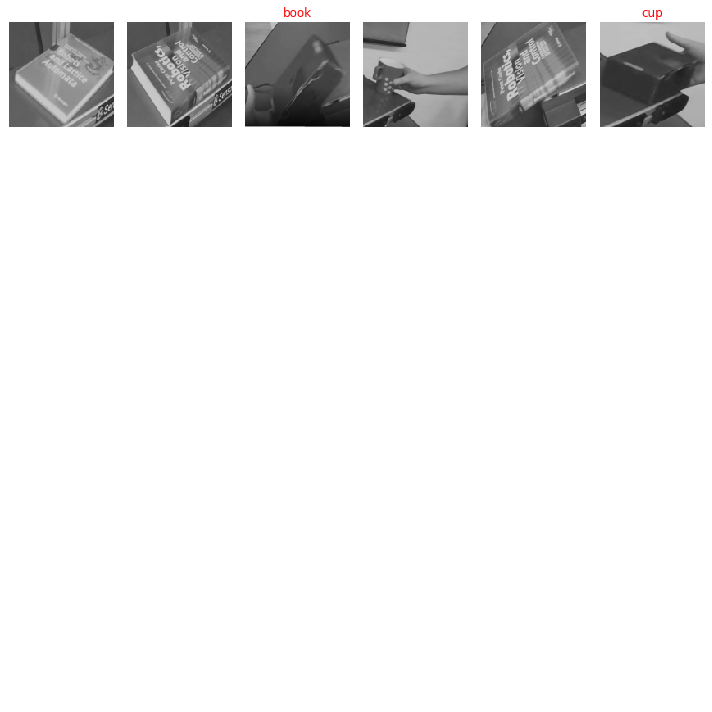

In [92]:
labels_dic = {0: 'cup', 1: 'box', 2: 'book'}
fig = plot_grid(test_data_show, test_labels_show, pred, labels_dic)

NameError: name 'cnn_model_4' is not defined

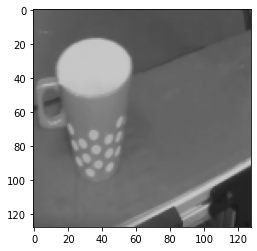

In [6]:
image = test_data2[3]
plt.imshow(image)
pred = cnn_model_4.predict(np.expand_dims(image,0))
#print(pred)

prediction = labels_dic[np.argmax(pred)]
print(prediction)

In [14]:
def initialize_network():
    from tensorflow.keras.models import load_model
    model = load_model('model.h5')

initialize_network()

In [22]:
def classifier(frame):
    labels_dic = {0: 'cup', 1: 'box', 2: 'book'}
    #Make predictions
    pred = model.predict(np.expand_dims(frame,0))
    prediction = labels_dic[np.argmax(pred)]
    return prediction

classifier(test_data2[7])

'book'

CNN Model 5 - pretrained model VGG16

- my computer died trying

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16

input_shape = (128, 128, 3)

cnn_model_4 = keras.Sequential()
cnn_model_4.add(VGG16(include_top=False,input_shape=input_shape))
cnn_model_4.add(layers.Flatten())
cnn_model_4.add(layers.Dense(3,activation="softmax"))

cnn_model_4.compile(optimizer=keras.optimizers.Adam(),
                    loss=tf.keras.losses.sparse_categorical_crossentropy,
                    metrics=["accuracy"])
                    #metrics=[tf.keras.metrics.CategoricalCrossentropy, "accuracy"])


batch_size = 32 # 16, 32, 64, 128
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=10) # 50

cnn_history_4 = cnn_model_4.fit(raw_data2, raw_labels2,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=0,
            callbacks=[PrintDot(), early_stop] # early_stop
            )

2022-05-05 08:25:38.955970: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rebeca/anaconda3/envs/tensorflow/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-05 08:25:38.956000: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-05 08:25:38.956021: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rebeca-UX430UAR): /proc/driver/nvidia/version does not exist
2022-05-05 08:25:38.956223: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-05-05 08:25:38.987545: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 1999965000 Hz
2022-05-05 08:25:38.988641: I tensorflo


....................................Epoch 00036: early stopping


,loss,accuracy,val_loss,val_accuracy,epoch
35,0.000017,1.0,0.195168,0.955882,35


Test loss: 5.172086238861084
Test accuracy: 0.3461538553237915


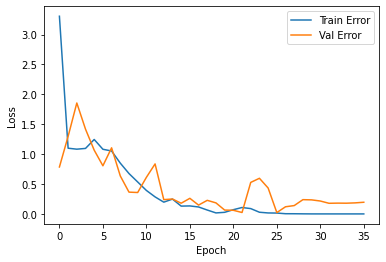

In [11]:
show_final_score(cnn_history_4)

score = cnn_model_4.evaluate(test_data2, test_labels2, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [65]:
cheat_data.shape

(1951, 128, 128, 1)

In [67]:
for i in range(1951):
    cv2.imshow("shiit", cheat_data[i])
    cv2.waitKey(1)
cv2.destroyAllWindows()